Рустам Шамсутдинов БВТ2201

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import os

In [ ]:
batch_size = 128
epochs = 50
lr = 1e-3
latent_dim = 32
hidden_dim = 400
image_dim = 28 * 28
num_classes = 10
device = torch.device("cudo" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [3]:
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

100.0%
100.0%
100.0%
100.0%


In [4]:
class CVAE(nn.Module):
    def __init__(self, image_dim=784, hidden_dim=400, latent_dim=32, n_classes=10):
        super().__init__()
        self.image_dim = image_dim
        self.n_classes = n_classes
        enc_input = image_dim + n_classes

        self.encoder_fc = nn.Sequential(
            nn.Linear(enc_input, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim//2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim//2, latent_dim)

        dec_input = latent_dim + n_classes
        self.decoder_fc = nn.Sequential(
            nn.Linear(dec_input, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, image_dim),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        if y.dim() == 1:
            y_oh = F.one_hot(y, num_classes=self.n_classes).float()
        else:
            y_oh = y.float()
        inp = torch.cat([x, y_oh], dim=1)
        h = self.encoder_fc(inp)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        if y.dim() == 1:
            y_oh = F.one_hot(y, num_classes=self.n_classes).float()
        else:
            y_oh = y.float()
        inp = torch.cat([z, y_oh.to(z.device)], dim=1)
        recon = self.decoder_fc(inp)
        return recon

    def forward(self, x, y):
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') 
    # KL divergence between N(mu, sigma) and N(0,1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [6]:
model = CVAE(image_dim=image_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, n_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        xb_flat = xb.view(xb.size(0), -1)
        optimizer.zero_grad()
        recon, mu, logvar = model(xb_flat, yb)
        loss, bce, kld = loss_function(recon, xb_flat, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_epoch_loss = train_loss / len(train_ds)
    print(f"Epoch {epoch}/{epochs}  Avg loss/img: {avg_epoch_loss:.4f}")

Epoch 1/50  Avg loss/img: 174.1995
Epoch 2/50  Avg loss/img: 126.9071
Epoch 3/50  Avg loss/img: 116.0914
Epoch 4/50  Avg loss/img: 110.5024
Epoch 5/50  Avg loss/img: 107.2905
Epoch 6/50  Avg loss/img: 105.1840
Epoch 7/50  Avg loss/img: 103.6284
Epoch 8/50  Avg loss/img: 102.4290
Epoch 9/50  Avg loss/img: 101.4957
Epoch 10/50  Avg loss/img: 100.6541
Epoch 11/50  Avg loss/img: 99.8853
Epoch 12/50  Avg loss/img: 99.2532
Epoch 13/50  Avg loss/img: 98.7778
Epoch 14/50  Avg loss/img: 98.2375
Epoch 15/50  Avg loss/img: 97.8383
Epoch 16/50  Avg loss/img: 97.5533
Epoch 17/50  Avg loss/img: 97.2239
Epoch 18/50  Avg loss/img: 96.9132
Epoch 19/50  Avg loss/img: 96.6273
Epoch 20/50  Avg loss/img: 96.3355
Epoch 21/50  Avg loss/img: 96.1252
Epoch 22/50  Avg loss/img: 95.9105
Epoch 23/50  Avg loss/img: 95.7298
Epoch 24/50  Avg loss/img: 95.5418
Epoch 25/50  Avg loss/img: 95.4077
Epoch 26/50  Avg loss/img: 95.2385
Epoch 27/50  Avg loss/img: 95.1243
Epoch 28/50  Avg loss/img: 94.9694
Epoch 29/50  Avg lo

In [ ]:
def generate_grid(model, n_rows=10, n_cols=10, latent_dim=32, device='cpu'):
    model.eval()
    imgs = []
    with torch.no_grad():
        for cls in range(n_rows):
            z = torch.randn(n_cols, latent_dim).to(device)
            labels = torch.full((n_cols,), cls, dtype=torch.long).to(device)
            recon = model.decode(z, labels)
            recon_imgs = recon.view(n_cols, 1, 28, 28)
            imgs.append(recon_imgs)
    rows = torch.cat(imgs, dim=0)
    grid = utils.make_grid(rows, nrow=n_cols, pad_value=1.0)
    return grid

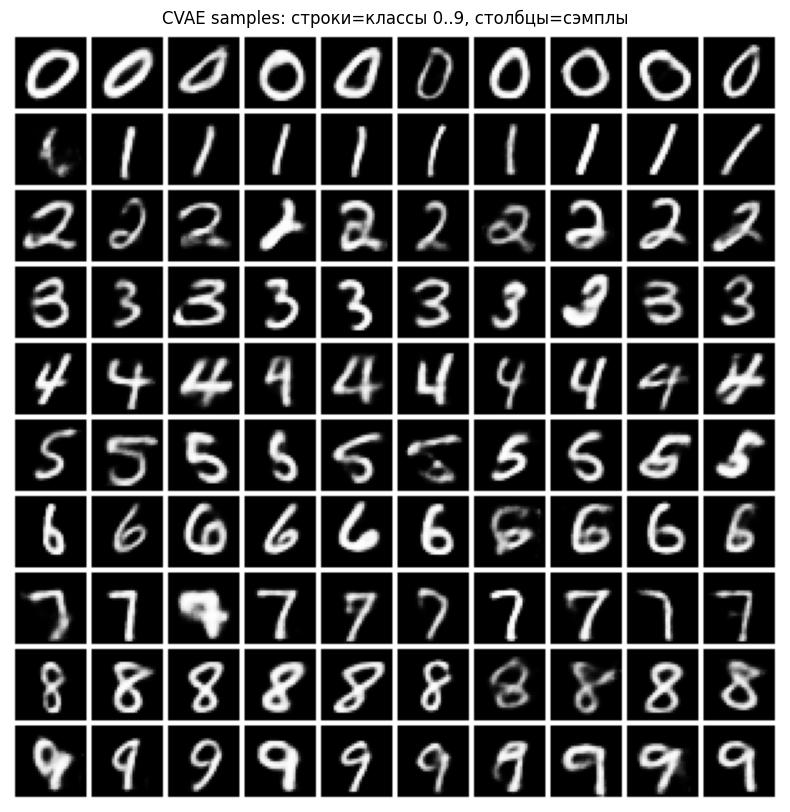

In [10]:
grid = generate_grid(model, n_rows=10, n_cols=10, latent_dim=latent_dim, device=device)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(grid.cpu().permute(1,2,0).squeeze(), cmap='gray')
plt.title("CVAE samples: строки=классы 0..9, столбцы=сэмплы")
plt.savefig(os.path.join("results", "cvae_samples.png"), bbox_inches='tight')
plt.show()